In [1]:
#all imports
import networkx as nx
import matplotlib.pyplot as plt
import random 
from string import ascii_lowercase
import numpy as np
import time
import random, operator, pandas as pd
from numpy.random import choice
from IPython.display import clear_output
import math
import datetime
from networkx.algorithms import tournament
from bokeh.models import CustomJS, Slider, Button
from bokeh.layouts import row, column
from bokeh.plotting import show
from bokeh.io import output_notebook
from datetime import timedelta, date
import warnings
warnings.simplefilter('ignore')

In [2]:
output_notebook()

#city class struct
class City:
    def __init__(self, key, x, y, name):
        self.key = key
        self.x = x
        self.y = y
        self.name = name
     
    def distance(self, city):
        xDist = abs(self.x - city.x)
        yDist = abs(self.y - city.y)
        dist = math.sqrt((xDist ** 2) + (yDist ** 2))
        return dist
    
    def __repr__(self):
        return "(City :" + self.name + "; with key: "+ str(self.key) + "; X:" + str(self.x) + "; Y: " + str(self.y) + ")"

class Road:
    def __init__(self, key, id_city_1, id_city_2, trafic):
        self.key = key
        self.id_city_1 = id_city_1
        self.id_city_2 = id_city_2
        self.trafic = trafic
        #self.traficList = generateTraficList()
    
    def reverseCities(self):
        city1 = self.id_city_2
        city2 = self.id_city_1
        #reassign the good cities
        self.id_city_1 = city1
        self.id_city_2 = city2
        
            
    def generateTraficList(self):
        tL = []
        start_date = startDate
        end_date = endDate
        delta = timedelta(minutes=1)
        while start_date <= end_date:
            print (start_date.strftime("%Y-%m-%d"))
            start_date += delta
            nbrCars = random.randint(0,100)
            if (timedelta(hours=7) <= timedelta(hours=start_date.hour) < timedelta(hours=9)) or (timedelta(hours=17) <= timedelta(hours=start_date.hour) < timedelta(hours=19)):
                nbrCars = nbrCars * 5
            trafic = Trafic(self.key,start_date,nbrCars)
            tL.append(trafic)
        return tL
        

    def __repr__(self):
        return "(Road :" + str(self.key) + "; City 1 => " + str(self.id_city_1) + "; City 2 => " + str(self.id_city_2) + ")"

class Trafic:
    def init(self, id_road, date, nbr_vehicules):
        self.id_road = id_road
        self.date = date
        self.nbr_vehicules = nbr_vehicules

    def __repr__(self):
        return "(Trafic : Road:" + self.id_road + "; Date:" + str(self.date) + "; Nombre de véhicules: " + str(self.nbr_vehicules) + ")"
        
#class to calcul the route distance then the fitness value
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self, citiesList):
        if self.distance ==0:
            pathDistance = 0
            for roadIndex in range(0, len(self.route)):
                fromCity = self.route[i].id_city_1
                toCity = self.route[i].id_city_2
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                #do not forget the come back to the start's city
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity) * road.trafic
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

def createRoute(roadsList):
    #return the first random route from a list of cities given
    route = []
    citiesBanned = []
    roadsList = random.sample(roadsList, len(roadsList))
    
    roadsListClone = roadsList.copy()
    firstRoad = random.randint(0,len(roadsList)-1)
    currentCity = roadsListClone[firstRoad].id_city_2
    citiesBanned.append(roadsListClone[firstRoad].id_city_1)
    route.append(roadsListClone[firstRoad])
    roadsListClone.pop(firstRoad)
    #tant qu'on a pas de boucle fermée avec toutes les villes reliées
    for i in range(nbr_cities):
        for j in range(0, len(roadsListClone)):
            tempRoad = roadsListClone[j]
            if (currentCity == tempRoad.id_city_1) and ((tempRoad.id_city_1 in citiesBanned) == False):
                route.append(tempRoad)
                citiesBanned.append(tempRoad.id_city_1)
                currentCity = tempRoad.id_city_2
                roadsListClone.pop(j)
                break
            elif (currentCity == tempRoad.id_city_2) and ((tempRoad.id_city_2 in citiesBanned) == False):
                tempRoad.reverseCities()
                route.append(tempRoad)
                citiesBanned.append(tempRoad.id_city_1)
                currentCity = tempRoad.id_city_2
                roadsListClone.pop(j)
                break
    if(len(route) < nbr_cities):
        return False
    return route

def initialPopulation(popSize, roadsList, citiesList):
    population = []
    while len(population) < popSize:
        #population.append(createRoute(roadsList))
        G.remove_edges_from(G.edges())
        route = createRoute(roadsList)
        if(route != False):
            print("INDIVIDU: " + str(len(population)))
            population.append(route)
            for road in route:
                G.add_edge(citiesList[road.id_city_1].key,citiesList[road.id_city_2].key, label=road.trafic)
            clear_output(True)
            displayGraph()
    return population

def rankRoutes(population, citiesList):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness(citiesList)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selectOne(popRanked):
    max = sum([indiv[1] for indiv in popRanked])
    selection_probs = [indiv[1]/max for indiv in popRanked]
    return popRanked[choice(len(popRanked), p=selection_probs)][0]

def selection(popRanked, eliteSize):
    selectionResults = []
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    
    for i in range(0, len(popRanked) - eliteSize):
        indiv = selectOne(popRanked);
        selectionResults.append(indiv)
        
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

def crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationRate)
        mutatedPop.append(mutatedIndividual)
    return mutatedPop

def nextGeneration(currentGen, citiesList, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen, citiesList)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(population, citiesList, popSize, eliteSize, mutationRate, generations):
    print(citiesList)
    pop = initialPopulation(popSize, population, citiesList)
    return
    initDist = 1 / rankRoutes(pop, citiesList)[0][1];
    for i in range(0, generations):
        print("Génération: n°" + str(i))
        pop = nextGeneration(pop, eliteSize, mutationRate)
        bestLocalRouteIndex = rankRoutes(pop)[0][0]
        bestLocalRoute = pop[bestLocalRouteIndex]
        
        # display the best route each iteration
        G.remove_edges_from(G.edges())
        for i in range(len(bestLocalRoute)):
            if i < len(bestLocalRoute)-1:
                G.add_edge(bestLocalRoute[i].key,bestLocalRoute[i+1].key)
            else:
                G.add_edge(bestLocalRoute[i].key,bestLocalRoute[0].key) 
        clear_output(True)
        displayGraph()
        
        #TODO check if the solution is not updating anymore
        
        
        
    print("Initial distance: " + str(initDist))
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

def generateCitiesList():
    citiesList = []
    citiesName = reloadCitiesName()
    i = 0
    while (len(citiesList) < nbr_cities):
        x,y = (random.randint(minX,maxX),random.randint(minY,maxY))
        newCity = City(i,x,y,"none")

        overlapping = False
        for city in citiesList:
            dist = newCity.distance(city)
            if(dist < minDistBetweenCities):
                overlapping = True
                
        if(overlapping == False):
            selection = random.randint(0, len(citiesName)-1)
            name = citiesName.pop(selection)
            newCity.name = name
            citiesList.append(newCity)
            G.add_node(newCity.key,pos=(newCity.x,newCity.y))
            labels[i] = newCity.name
            i = i + 1
        else:
            newCity = None
    return citiesList;

def generateRoadsList():
    roadsList = []
    i = 0
    while (len(roadsList) < nbr_roads):
        id_city_1,id_city_2 = (random.randint(0,nbr_cities-1),random.randint(0,nbr_cities-1))
        
        if(id_city_1 == id_city_2):
            continue
        
        overlapping = False
        for road in roadsList:
            if(id_city_1 == road.id_city_1 and id_city_2 == road.id_city_2) or (id_city_2 == road.id_city_1 and id_city_1 == road.id_city_2):
                overlapping = True
        
        if(overlapping == False):
            newRoad = Road(i,id_city_1,id_city_2,random.randint(0,50))
            roadsList.append(newRoad)
            i = i + 1
        else:
            continue
    return roadsList

#to reload cities name file txt
def reloadCitiesName():
    citiesName = []
    try:
        with open('FrenchCitieslist.txt', 'rU') as infile:
            wordSet = set(line.strip() for line in infile)
    except IOError:
           print('error opening file')

    for aWord in wordSet:
        citiesName.append(aWord)
    return citiesName

def generateManualyData():
    

def displayGraph():
    #Draw Graph
    plt.figure(figsize=(15, 15))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(minX,maxX)
    plt.ylim(minY,maxY)
    plt.title("Carte routière")
    ax = plt.subplot(1,1,1)
    pos = nx.get_node_attributes(G,'pos')
    edge_labels = dict([((u,v),d['label']) for u,v,d in G.edges(data=True)])
    
    #TODO : need to implement dynamic scale of node size for big amount of cities, same for roads
    nx.draw_networkx(G,pos, node_size=1000,node_color="skyblue", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos, labels,font_size=16,font_weight='bold')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.show()

    

def main():
    citiesList = generateCitiesList()
    roadsList = generateRoadsList()
   # for i in range(len(citiesList)):
    #    if i < len(citiesList)-1:
     #       G.add_edge(citiesList[i].key,citiesList[i+1].key)    
      #  else:
       #     G.add_edge(citiesList[i].key,citiesList[0].key)

    for road in roadsList:
        G.add_edge(citiesList[road.id_city_1].key,citiesList[road.id_city_2].key, label=road.trafic)

    #G = nx.connected_watts_strogatz_graph(nbr_cities, 10, .5)
    #path = nx.single_target_shortest_path(G, 4)
    #print(path)
    #nx.draw(G) 
    displayGraph()
    G.remove_edges_from(G.edges())
    
    geneticAlgorithm(population=roadsList, citiesList=citiesList, popSize=50, eliteSize=10, mutationRate=0.01, generations=50)
    




Loading BokehJS ...

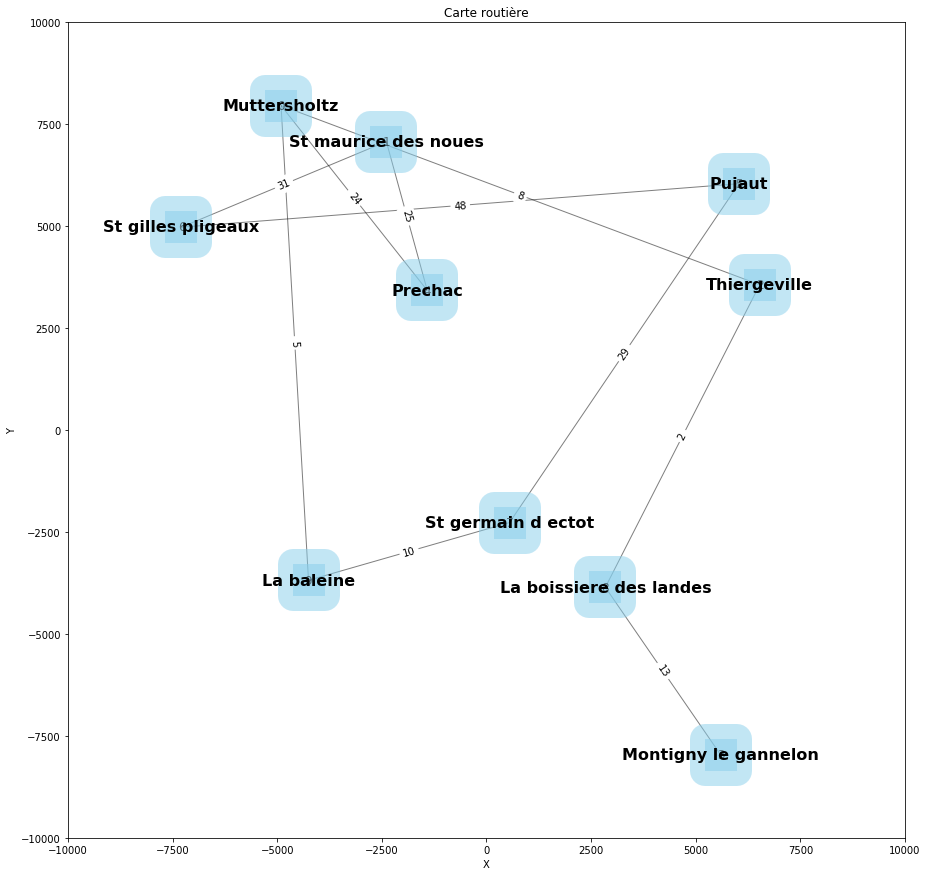

Time of Execution :
Wall time: 1min 14s


In [3]:
%%time 

nbr_cities = 10
nbr_roads = 40
nbr_trafic_record = 5000;

startDate = datetime.datetime(2020, 1, 1, 0, 0)
endDate = datetime.datetime(2020,1, 5, 19, 0)

#Not absolute if too long time execution, it's a preferred dist, reducing by 1% each iterations after 5000 iterations
minDistBetweenCities = 2000; 

#range
maxX = 10000;
maxY = 10000;
minX = -10000;
minY = -10000;

labels = {}
G = nx.Graph()
roadsLabel = {}

#nbr_cities = nbr_cities-1 #to fix fucked up bug of NetworkX

main()

print("Time of Execution :") #don't delete, using magic cell statement